In [49]:
# A cell to run functions directly.
using Reexport
using Distributions
using Statistics
using Meshes
using Distances
using Random
using GeoTables
using DataFrames
import CairoMakie as Mke
using Infiltrator
using AbstractGPs
using ProgressMeter
using Unitful
using JLD2
using Plots
using DataStructures
using POMDPModelTools
using POMDPs
using ParticleFilters
using LinearAlgebra
include("../src/config.jl");
include("../src/pomdp.jl")
# pomdp = CCSPOMDP();

FEATURE = :z


:z

In [50]:
visualize_gt(pomdp, 1)

### Test: Action function returns all actions

In [51]:
all_actions = POMDPs.actions(pomdp);

### Test: Observation function returns correct distributions

w/o scaling, For column permeability, with scaling factor: 1.5, mean uncertainty after scaling: 2.2908923270902517
w/o scaling, For column topSealThickness, with scaling factor: 15.0, mean uncertainty after scaling: 1.0
w/o scaling, For column z, with scaling factor: 150.0, mean uncertainty after scaling: 1.3333333333333326
w/o scaling, For column bottomSeal, with scaling factor: 1.0, mean uncertainty after scaling: 1.0
w/o scaling, For column injectivity, with scaling factor: 0.6324555320336759, mean uncertainty after scaling: 1.2472191289246453
w/o scaling, For column salinity, with scaling factor: 23.979157616563597, mean uncertainty after scaling: 1.377879067493836
Total Layer Col uncertainty: 8.249323856842066
-----------------------------------
w/o scaling, For column permeability, with scaling factor: 1.5, mean uncertainty after scaling: 2.2908923270902517
w/o scaling, For column topSealThickness, with scaling factor: 15.0, mean uncertainty after scaling: 0.9900271373009276
w/o 

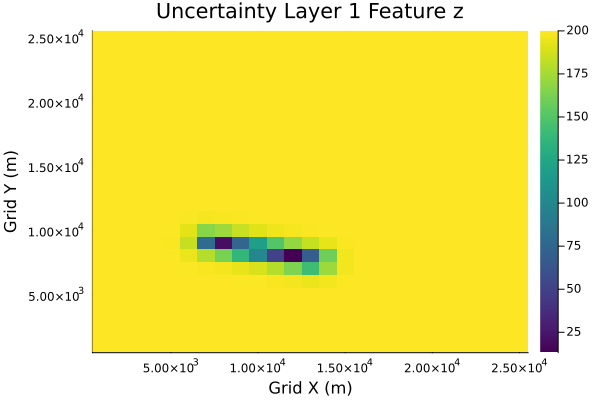

In [52]:
# Taking a seismic line action first
curstate = rand(initialstate(pomdp))
step = POMDPs.gen(pomdp, curstate, all_actions[21], nothing)
println(typeof(step), "\nReward: ", step.r)
curstate = step.sp

println(curstate.rocktype_belief)
visualize_uncertainty(curstate, 1, FEATURE)

w/o scaling, For column permeability, with scaling factor: 1.5, mean uncertainty after scaling: 2.2908923270902517
w/o scaling, For column topSealThickness, with scaling factor: 15.0, mean uncertainty after scaling: 1.0
w/o scaling, For column z, with scaling factor: 150.0, mean uncertainty after scaling: 1.3333333333333326
w/o scaling, For column bottomSeal, with scaling factor: 1.0, mean uncertainty after scaling: 1.0
w/o scaling, For column injectivity, with scaling factor: 0.6324555320336759, mean uncertainty after scaling: 1.2472191289246453
w/o scaling, For column salinity, with scaling factor: 23.979157616563597, mean uncertainty after scaling: 1.377879067493836
Total Layer Col uncertainty: 8.249323856842066
-----------------------------------
w/o scaling, For column permeability, with scaling factor: 1.5, mean uncertainty after scaling: 0.9974272046766808
w/o scaling, For column topSealThickness, with scaling factor: 15.0, mean uncertainty after scaling: 0.9974882830116909
w/o 

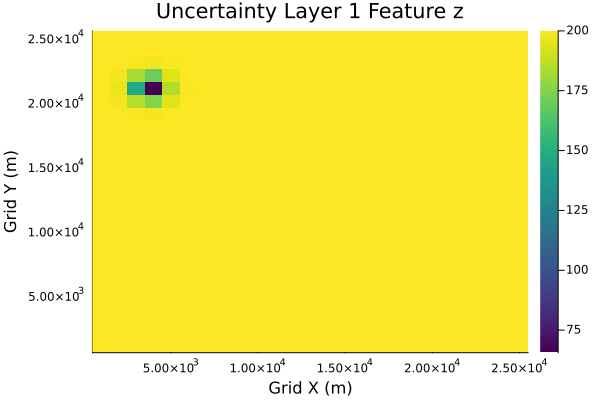

In [53]:
curstate = rand(initialstate(pomdp))
step = POMDPs.gen(pomdp, curstate, all_actions[2], nothing)
println(typeof(step), "\nReward: ", step.r)
curstate = step.sp

println(curstate.rocktype_belief)
visualize_uncertainty(curstate, 1, FEATURE)

w/o scaling, For column permeability, with scaling factor: 1.5, mean uncertainty after scaling: 0.9974272046766808
w/o scaling, For column topSealThickness, with scaling factor: 15.0, mean uncertainty after scaling: 0.9974882830116909
w/o scaling, For column z, with scaling factor: 150.0, mean uncertainty after scaling: 1.3298984445898945
w/o scaling, For column bottomSeal, with scaling factor: 1.0, mean uncertainty after scaling: 1.0
w/o scaling, For column injectivity, with scaling factor: 0.6324555320336759, mean uncertainty after scaling: 0.49875674324879
w/o scaling, For column salinity, with scaling factor: 23.979157616563597, mean uncertainty after scaling: 1.4558394712902454
Total Layer Col uncertainty: 6.279410146817301
-----------------------------------
w/o scaling, For column permeability, with scaling factor: 1.5, mean uncertainty after scaling: 0.9950196518541393
w/o scaling, For column topSealThickness, with scaling factor: 15.0, mean uncertainty after scaling: 0.9951285

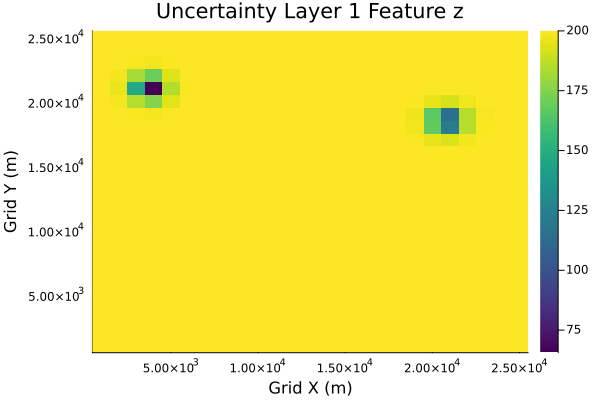

In [54]:
step = POMDPs.gen(pomdp, curstate, all_actions[7], nothing)
println(typeof(step), "\nReward: ", step.r)
curstate = step.sp

println(curstate.rocktype_belief)
visualize_uncertainty(curstate, 1, FEATURE)